## Neural network application to identify patients at high-risk for heart events (I)

> "We analyzed a dataset containing the medical records of 299 heart failure patients collected at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad (Punjab, Pakistan), during April–December 2015 [52, 66]. The patients consisted of 105 women and 194 men, and their ages range between 40 and 95 years old (Table 1). All 299 patients had left ventricular systolic dysfunction and had previous heart failures that put them in classes III or IV of New York Heart Association (NYHA) classification of the stages of heart failure [67]." 

https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5


**Motive** Predict patients that died before their next follow-up. Machine learning tools can be immensely helpful to identify patients at high risk for life-threatening heart events. 

**Results** This model applies a random forest classifer with a few significant variables. That output is fed into a neural network and run through a few dozen one-cycle iterations to achieve an accuracy of 98% on the hold-out dataset. between

**Part I** In this notebook, you'll see exploratory data analysis of the dataset. This will help identify the critical features to build a random forest classifier. We also prep the datasets to be fed into the neural network in this part. In the next notebook, you'll see  development and inference of the neural network. 

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

In [7]:
columns = df.columns
columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

Which features are categorical? Which are numerical


In [9]:
catVar = []
numVar =[]

In [10]:
for feature in columns[:-1]:
    print(df[feature].describe())
    featureType = input("what data type is this?")
    if featureType == 'c':
        catVar.append(feature)
    if featureType == 'n':
        numVar.append(feature)

count    299.000000
mean      60.833893
std       11.894809
min       40.000000
25%       51.000000
50%       60.000000
75%       70.000000
max       95.000000
Name: age, dtype: float64
what data type is this?n
count    299.000000
mean       0.431438
std        0.496107
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: anaemia, dtype: float64
what data type is this?c
count     299.000000
mean      581.839465
std       970.287881
min        23.000000
25%       116.500000
50%       250.000000
75%       582.000000
max      7861.000000
Name: creatinine_phosphokinase, dtype: float64
what data type is this?n
count    299.000000
mean       0.418060
std        0.494067
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: diabetes, dtype: float64
what data type is this?c
count    299.000000
mean      38.083612
std       11.834841
min       14.000000
25%       30.000000
50%       38.00000

In [12]:
df.DEATH_EVENT.describe()

count    299.00000
mean       0.32107
std        0.46767
min        0.00000
25%        0.00000
50%        0.00000
75%        1.00000
max        1.00000
Name: DEATH_EVENT, dtype: float64

Text(0, 0.5, 'Frequency')

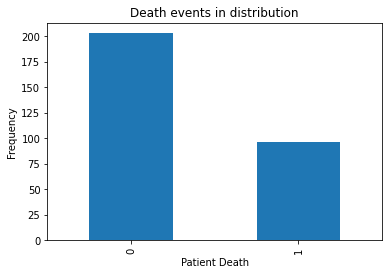

In [13]:
ax = df.DEATH_EVENT.value_counts().plot(kind='bar', title = 'Death events in distribution')
ax.set_xlabel("Patient Death")
ax.set_ylabel("Frequency")

In [14]:
##method to separate a train and test set
msk = np.random.rand(len(df))< 0.8
train = df[msk]
test = df[~msk]

In [15]:
df.info()
print('_'*40)
train.info()
print('_'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB
__________________

In [16]:
train.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000,244.000000
mean,61.193992,0.418033,616.721311,0.413934,37.639344,0.331967,262790.887951,1.391107,136.610656,0.655738,0.340164,127.459016,0.331967
std,12.183953,0.494249,1051.762751,0.493549,11.597194,0.471887,96902.809917,1.010249,4.439818,0.476104,0.474738,78.494491,0.471887
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.500000,113.000000,0.000000,0.000000,4.000000,0.000000
25%,51.000000,0.000000,120.250000,0.000000,30.000000,0.000000,212750.000000,0.900000,134.000000,0.000000,0.000000,67.500000,0.000000
50%,60.000000,0.000000,245.000000,0.000000,36.500000,0.000000,258000.000000,1.100000,137.000000,1.000000,0.000000,112.000000,0.000000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,304000.000000,1.400000,140.000000,1.000000,1.000000,200.250000,1.000000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.400000,146.000000,1.000000,1.000000,285.000000,1.000000


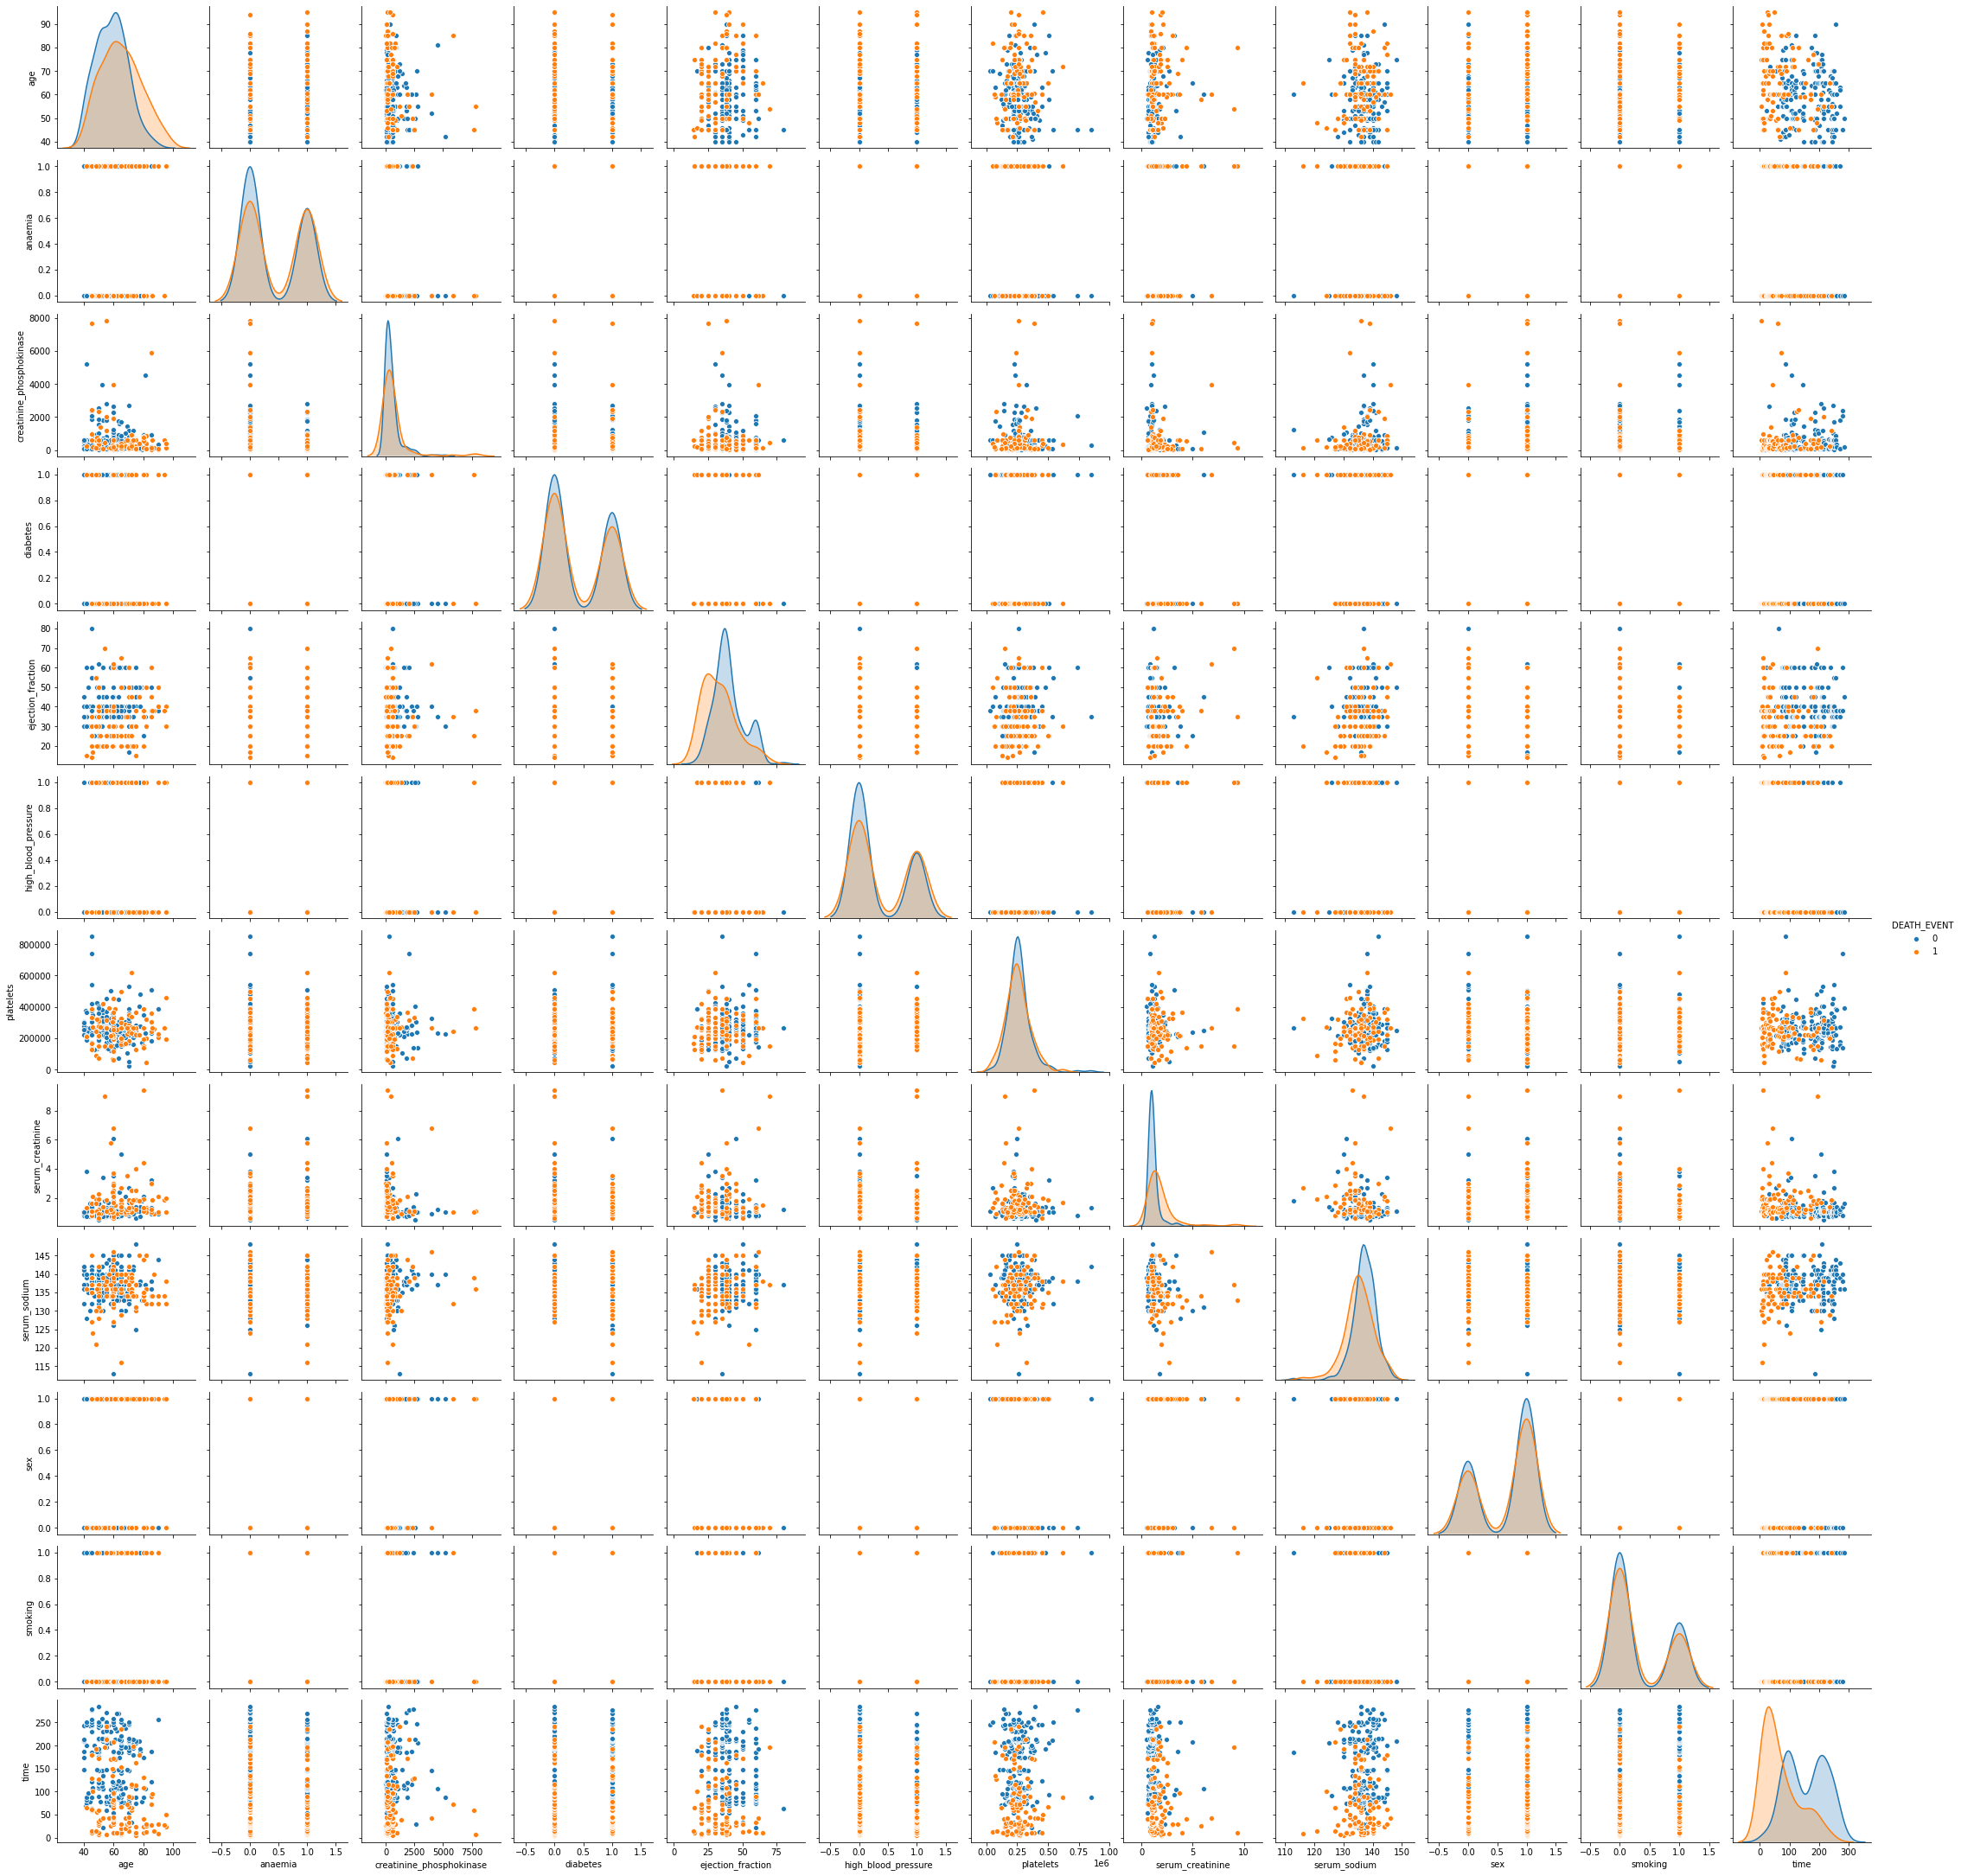

In [17]:
sns.pairplot(df, hue='DEATH_EVENT')

In [73]:
catVar

['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']

In [74]:
df[['anaemia','DEATH_EVENT']].groupby(['anaemia'], as_index=False).mean().sort_values(by='DEATH_EVENT',ascending=False)

,anaemia,DEATH_EVENT
1,1,0.356589
0,0,0.294118


In [75]:
df[['diabetes','DEATH_EVENT']].groupby(['diabetes'], as_index=False).mean().sort_values(by='DEATH_EVENT',ascending=False)

,diabetes,DEATH_EVENT
0,0,0.321839
1,1,0.320000


In [76]:
df[['high_blood_pressure','DEATH_EVENT']].groupby(['high_blood_pressure'], as_index=False).mean().sort_values(by='DEATH_EVENT',ascending=False)

,high_blood_pressure,DEATH_EVENT
1,1,0.371429
0,0,0.293814


In [77]:
df[['sex','DEATH_EVENT']].groupby(['sex'], as_index=False).mean().sort_values(by='DEATH_EVENT',ascending=False)

,sex,DEATH_EVENT
0,0,0.323810
1,1,0.319588


In [78]:
df[['smoking','DEATH_EVENT']].groupby(['smoking'], as_index=False).mean().sort_values(by='DEATH_EVENT',ascending=False)

,smoking,DEATH_EVENT
0,0,0.325123
1,1,0.312500


Just a quick eyeball would suggest the high blood pressure should be incorporated as should anamia.

In [79]:
numVar

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'time']

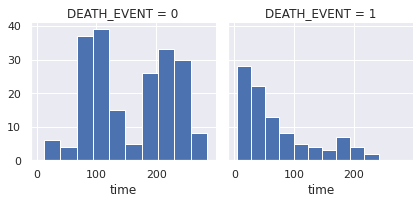

In [104]:
g = sns.FacetGrid(df, col='DEATH_EVENT')
g.map(plt.hist,'time',bins=10)

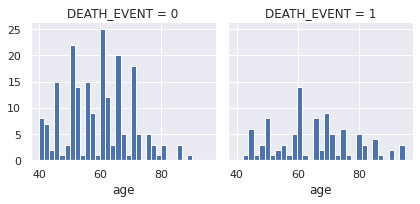

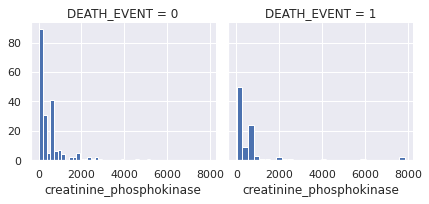

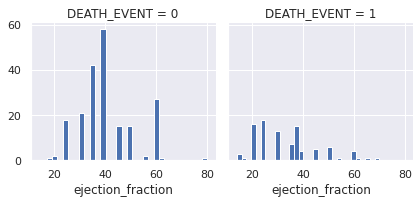

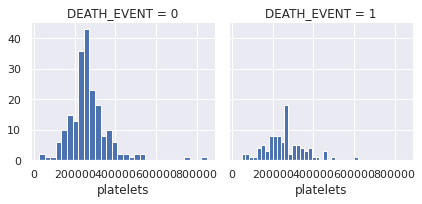

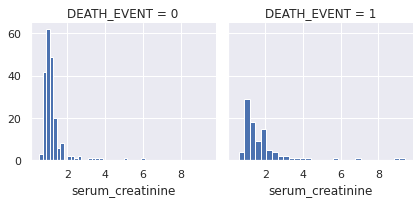

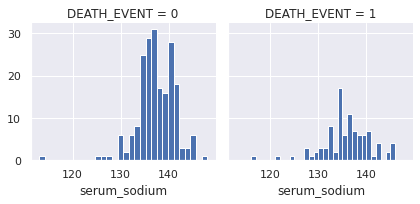

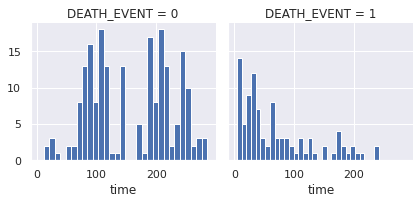

In [90]:
for feature in numVar:
    g = sns.FacetGrid(df, col='DEATH_EVENT')
    g.map(plt.hist,feature,bins=30)

Let's include ejection fracture, serum_sodium, serum_creatine, time

In [96]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [138]:
relevFeatures =['age', 'anaemia', 'ejection_fraction', 'diabetes', 'serum_creatinine', 'serum_sodium', 'time', 'DEATH_EVENT']

In [139]:
subset_train = train[relevFeatures]
subset_test = test[relevFeatures]

In [204]:
X_train = subset_train.drop("DEATH_EVENT", axis=1)
Y_train = subset_train["DEATH_EVENT"]
X_test  = subset_test.drop("DEATH_EVENT", axis=1).copy()
Y_test = subset_test["DEATH_EVENT"]
X_train.shape, Y_train.shape, X_test.shape

((241, 7), (241,), (58, 7))

In [205]:
# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)


In [206]:
getValAccuracy(Y_pred)

0.8275862068965517

In [207]:
def getValAccuracy(preds):
    
    return 1- (sum(abs(Y_test.to_numpy()- preds))/len(preds))

In [208]:
coeff_df = pd.DataFrame(df.columns)
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)


,Feature,Correlation
4,ejection_fraction,0.728279
1,anaemia,0.301121
0,age,0.043404
6,platelets,-0.019510
5,high_blood_pressure,-0.057589
2,creatinine_phosphokinase,-0.083071
3,diabetes,-0.190172
7,serum_creatinine,NaN
8,serum_sodium,NaN
9,sex,NaN


In [209]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

83.82

In [210]:
getValAccuracy(Y_pred)

0.9137931034482758

In [211]:
#k nearest neighbords
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

91.29

In [212]:
getValAccuracy(Y_pred)

0.8275862068965517

In [213]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

79.25

In [214]:
getValAccuracy(Y_pred)

0.8620689655172413

In [215]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc



83.82

In [216]:
getValAccuracy(Y_pred)

0.8620689655172413

In [217]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd


80.08

In [218]:
getValAccuracy(Y_pred)

0.896551724137931

In [219]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree



100.0

In [220]:
getValAccuracy(Y_pred)

0.7758620689655172

In [221]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

100.0

In [222]:
getValAccuracy(Y_pred)

0.896551724137931

In [226]:
##Let's use the RF model and add it to a feature in our dataset

random_forest.predict(X_train)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [229]:
## add these values to the dataframe for train and test

train['RFPred'] = random_forest.predict(X_train)
test['RFPred'] = random_forest.predict(X_test)

In [295]:
full = train.append(test)
full.shape


(299, 15)

In [297]:
full.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,RFPred,xAge
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,1,0.272727
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,1,0.454545
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,1,0.454545
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1,1,0.909091
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1,1,0.636364


In [296]:
df.shape

(299, 13)

In [249]:
numVar

['age',
 'creatinine_phosphokinase',
 'ejection_fraction',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'time']

In [298]:
minMaxScaler = preprocessing.MinMaxScaler()
for varToNormalize in numVar:
    pull = full[varToNormalize]
    x = pull.to_numpy().reshape(-1,1)
    NormalizedData = minMaxScaler.fit_transform(x)
    newtitle = 'x_' + varToNormalize 
    full[newtitle] = NormalizedData

In [305]:
full.shape

(299, 14)

In [303]:
for feature in numVar:
    del full[feature]

In [288]:
x = train.age.to_numpy().reshape(-1,1)
minMaxScaler = preprocessing.MinMaxScaler()
Xage = minMaxScaler.fit_transform(x)

In [290]:
train['xAge'] = Xage

In [292]:
train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT,RFPred,xAge
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1,1,0.272727
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1,1,0.454545
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1,1,0.454545
5,90.0,1,47,0,40,1,204000.00,2.1,132,1,1,8,1,1,0.909091
6,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1,1,0.636364


In [284]:
normalizer.transform(x)

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [278]:
from sklearn import preprocessing
xnorm= preprocessing.normalize(train.age.to_numpy().reshape(-1,1), norm='l2')
xnorm

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [246]:
y_test = test['DEATH_EVENT']


x_test = test.loc[:,test.columns != 'DEATH_EVENT']

In [309]:
## PICK UP FROM FULL

msk = np.random.rand(len(full)) < 0.8 
trainNormd = full[msk]
testNormd = full[~msk]

In [312]:
msk = np.random.rand(len(trainNormd)) < 0.8 
trainNORM = trainNormd[msk]
valNORM = trainNormd[~msk]

In [319]:
Y_Train = trainNORM['DEATH_EVENT']
Y_valid = valNORM['DEATH_EVENT']

X_Train = trainNORM.loc[:,trainNORM.columns != 'DEATH_EVENT']
X_valid = valNORM.loc[:,valNORM.columns != 'DEATH_EVENT']

In [320]:
y_test = testNormd['DEATH_EVENT']

x_test = testNormd.loc[:,testNormd.columns != 'DEATH_EVENT']

In [321]:
X_Train.head()

,anaemia,diabetes,high_blood_pressure,sex,smoking,RFPred,x_age,x_creatinine_phosphokinase,x_ejection_fraction,x_platelets,x_serum_creatinine,x_serum_sodium,x_time
2,0,0,0,1,1,1,0.454545,0.015693,0.090909,0.165960,0.089888,0.457143,0.010676
5,1,0,1,1,1,1,0.909091,0.003062,0.393939,0.216875,0.179775,0.542857,0.014235
6,1,0,0,1,0,1,0.636364,0.028451,0.015152,0.123530,0.078652,0.685714,0.021352
7,1,1,0,1,1,1,0.363636,0.037254,0.696970,0.519942,0.067416,0.514286,0.021352
8,0,0,0,0,0,1,0.454545,0.017096,0.772727,0.288833,0.112360,0.714286,0.021352


In [322]:
X_Train.to_csv('xTrain.csv')
Y_Train.to_csv('yTrain.csv')
X_valid.to_csv('xValid.csv')
Y_valid.to_csv('yValid.csv')
x_test.to_csv('xTest.csv')
y_test.to_csv('yTest.csv')